# Imports

In [1]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import time
import datetime
import os
import csv
import traceback
import pytz
import keras
from keras import layers
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import load_model, Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# for saving pandas data
import pickle
import matplotlib.image as mpimg
# html map drawing
from ipyleaflet import Map, Heatmap,FullScreenControl,Marker,basemaps, WidgetControl, Popup, CircleMarker
from ipywidgets import IntSlider, ColorPicker, Button, link
#self created file -> get sensor descriptions
import sensors
# Feature Importance Framework
from eli5.permutation_importance import get_score_importances



Using TensorFlow backend.
C:\Users\ibisc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ibisc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ibisc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ibisc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Function definitions

In [2]:
def lambda_ratio(load,count):
    """ 
    Calculate the ratio for load and count. Return a value, that measures the time for a vehicle to pass a sensor. 
    Parameters: 
    load (int): Percentage of one minute with the sensor registering a vehicle.
    count (int): Counted vehicles.
    Returns:
    float : ratio
    """
    if count == 0:
            ratio = load*0.6
    else:    
        ratio = load*0.6/count
    return ratio

def calc_sin_time(hour, minute):
    return np.sin((2*np.pi)*((hour*3600+minute*60)/(24*60*60)))
def calc_cos_time(hour, minute):  
    return np.cos((2*np.pi)*((hour*3600+minute*60)/(24*60*60)))
def calc_bit(day, var):
    if day == var:
        return 1
    else:
        return 0

def calc_ratio_data(data):
    """
    1. Compute Ratio between vehicle count and sensor load 
    2. Compute a continuous time variable for hour of the day and day of the week
    Parameters: 
    load (int): Percentage of one minute with the sensor registering a vehicle.
    count (int): Counted vehicles.
    Returns:
    float : ratio    
    """
    df = pd.DataFrame()
    # take two steps
    for index in range(0,data.shape[1],2):
        load = data.iloc[: , index]
        count = data.iloc[: , index+1]
        # Exclude defective sensor values or sensors with a lot of missing data
        #@TODO: Nur die bedingeungen die nicht auf nan prüfen können weg 
        if ((load.isnull().mean(axis = 0) <= .1) & (count.isnull().mean(axis = 0) <= .1)):
            # new col name is only sensor name
            newcolname = load.name.split("_")[0]+"_"+load.name.split("_")[1]
            # calc the ratio of each load and count column pairwise
            df[newcolname]= data.apply(lambda x: lambda_ratio(x[load.name],x[count.name]),axis=1)
    return df

def add_synthetic_columns(df):
    # We need these columns only for grouping the data by hour, minute and weekday.
    df["hour"] = df.index.hour
    df["minute"] = df.index.minute
    df["dayofweek"] = df.index.dayofweek
    # Compute a continuous time variable for hour of the day.
    df['sin_time'] = df.apply(lambda x: calc_sin_time(x.hour,x.minute),axis=1)
    df['cos_time'] = df.apply(lambda x: calc_cos_time(x.hour,x.minute),axis=1)
    # Set the weekday as categorial data
    df['monday'] = df.apply(lambda x: calc_bit(x.dayofweek, 0),axis=1)
    df['tuesday'] = df.apply(lambda x: calc_bit(x.dayofweek, 1),axis=1)
    df['wednesday'] = df.apply(lambda x: calc_bit(x.dayofweek, 2),axis=1)
    df['thursday'] = df.apply(lambda x: calc_bit(x.dayofweek, 3),axis=1)
    df['friday'] = df.apply(lambda x: calc_bit(x.dayofweek, 4),axis=1)
    df['saturday'] = df.apply(lambda x: calc_bit(x.dayofweek, 5),axis=1)
    df['sunday'] = df.apply(lambda x: calc_bit(x.dayofweek, 6),axis=1)
    return df

def generator(indexes, data, float_data_n, lookback, delay, min_index, max_index,
                  shuffle=False, batch_size=128, step=6):
    """
    Generator function for training data.

    Parameters:
    indexes: the indices of the sensors which are supposed to be predicted
    data: The original array of floating point data
    float_data_n: The original array of floating point data, which we just normalized.
    lookback: How many timesteps back should our input data go.
    delay: How many timesteps in the future should our target be.
    min_index and max_index: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
    shuffle: Whether to shuffle our samples or draw them in chronological order.
    batch_size: The number of samples per batch.
    step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
        lookback // step,
        data.shape[-1]))
        # init target array -> number of sensors to predict is important
        targets = np.zeros((len(rows), len(indexes)))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            # normalized input data
            samples[j] = float_data_n[indices]
            # predict first crossroad
            targets[j] = data[rows[j] + delay, indexes]
        yield samples, targets        

        

def evaluate_history(indexes, predict_sensors, data, min_index_training, max_index_training ,min_index_validation, max_index_validation):
    """ 
    Calculate the mean average error based on the value at the same time a week before. 
    """  
    # generate basemodel over training data
    hist_basemodel = data.iloc[min_index_training:max_index_training].groupby(["dayofweek","hour","minute"])
    t = []
    p = []
    batch_maes = []
    # compare with validation data
    for index, row in data.iloc[min_index_validation:max_index_validation].iterrows():
        y_pred = []
        y_true = row[indexes]
        for sensor in predict_sensors:
            # mean over all data for the sensor i
            y_pred += [hist_basemodel[sensor].mean()[row["dayofweek"]][row["hour"]][row["minute"]]]
        t += [y_true]
        p += [y_pred]
        # we compare the two vectors of senosdata for the same timespace
        mae = mean_absolute_error(y_true, y_pred)
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes), t,p


def naive_walk(indexes, float_data, min_index_validation ,max_index_validation, delay):
    """ 
    Calculate the mean average error based on using the last value from the seen set of data as the prediction. 

    Parameters: 
    indexes array: indexes of sensors to be predicted
    float_data (int): All sensor data.
    delay (int): How many timesteps is the prediction horizon.
    """ 
    plot_pred = []
    plot_true = []
    val_data = float_data[min_index_validation:max_index_validation]
    batch_maes = []
    for date in range(delay,len(val_data)):
        y_pred = val_data[date-delay,indexes]
        y_true = val_data[date,indexes]
        plot_pred += [y_pred]
        plot_true += [y_true]
        mae = mean_absolute_error(y_true, y_pred)
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes), plot_true, plot_pred

def generate_grid_list(index_dict,grid_resolution, draw):
    #get sectors for all sensors
    sensorlist, west, east, south, north, quad_x_dict, quad_y_dict, raster_x, raster_y = sensors.enrich_with_sectors(False, index_dict.keys(),sensors.create_sensor_list(), grid_resolution)
    if draw:
        # Draw everything to check
        plt.figure(num=None, figsize=(10, 20), dpi=80, facecolor='w', edgecolor='k')

        for sensor in sensorlist:
            plt.scatter(float(sensorlist[sensor].get("Location").get("lon")), float(sensorlist[sensor].get("Location").get("lat")))
            plt.annotate(sensorlist[sensor].get("ID"),
                         (float(sensorlist[sensor].get("Location").get("lon")), float(sensorlist[sensor].get("Location").get("lat"))))

        # Draw sectors
        plt.plot([west, east], [south, south], color='black', linewidth=0.1)
        plt.plot([west, west], [south, north], color='black', linewidth=0.1)

        for x_line in range(0, raster_x):
            plt.plot([quad_x_dict[x_line], quad_x_dict[x_line]], [south, north], color='black', linewidth=0.1)
        for y_line in range(0, raster_y):
            plt.plot([east, west], [quad_y_dict[y_line], quad_y_dict[y_line]], color='black', linewidth=0.1)

        plt.show()
    return sensorlist, raster_x, raster_y
    
def convert_to_sector(input_data, index_dict, sensorlist, raster_x, raster_y):
    """
    Build grid with sensor locations and calculate mean of all sensors located in one sector.
    """
    matrix = np.zeros((raster_y,raster_x))
    for y in range(raster_y):
        for x in range(raster_x):
            # los gehts
            values = []
            for i, sensor in enumerate(index_dict.keys()):
                # is the current sensor in this gird
                if (sensorlist[sensor]["sector"]["x"] == x) and (sensorlist[sensor]["sector"]["y"] == y):
                        # yes ? get the index of the sensor then get its value and add it to an array
                        values += [input_data[i]]
            # get the mean of all sensors in this sector
            matrix[y][x]= np.mean(values)
    return np.nan_to_num(matrix)              
        
    
def draw_comparison(grid_resolution, real, pred, index_dict):
    sensorlist, raster_x, raster_y = generate_grid_list(index_dict,grid_resolution, False)
    real = convert_to_sector(real, index_dict, sensorlist, raster_x, raster_y)
    pred = convert_to_sector(pred, index_dict, sensorlist, raster_x, raster_y)

    #plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 20))
    fig.suptitle('Vergleich zwischen Realität und Prognose')
    # color "mappable" object returned by ax1.imshow
    map_obj = axs[0].imshow(real, cmap='RdBu_r', interpolation='none', origin = "lower", vmin=0, vmax=30,alpha=0.5, zorder=1)
    axs[0].set_xlabel("Sektor")
    axs[0].set_ylabel("Sektor")
    axs[0].set_title("Realität")
    # add the colorbar using the figure's method,
    # telling which mappable we're talking about and
    # which axes object it should be near
    #fig.colorbar(map_obj, ax=axs[0])
    map_obj = axs[1].imshow(pred, cmap='RdBu_r', interpolation='none', origin = "lower", vmin=0, vmax=30,alpha=0.5,  zorder=1)
    cbar = fig.colorbar(map_obj, ax=axs[1])
    cbar.minorticks_on()
    cbar.set_label("Verweildauer [sec]")
    axs[1].set_xlabel("Sektor")
    axs[1].set_ylabel("Sektor")
    axs[1].set_title("Prognose")
    #draw sensors
    for sensor in sensorlist:
        axs[0].scatter(float(sensorlist[sensor].get("sector").get("x")), float(sensorlist[sensor].get("sector").get("y")))
        axs[0].annotate(sensorlist[sensor].get("ID"),
                     (float(sensorlist[sensor].get("sector").get("x")), float(sensorlist[sensor].get("sector").get("y"))))
    #draw sensors
    for sensor in sensorlist:
        axs[1].scatter(float(sensorlist[sensor].get("sector").get("x")), float(sensorlist[sensor].get("sector").get("y")))
        axs[1].annotate(sensorlist[sensor].get("ID"),
                     (float(sensorlist[sensor].get("sector").get("x")), float(sensorlist[sensor].get("sector").get("y"))))
    plt.show()

def draw_data(grid_resolution, real, index_dict):
    sensorlist, raster_x, raster_y = generate_grid_list(index_dict,grid_resolution, False)
    real = convert_to_sector(real, index_dict, sensorlist, raster_x, raster_y)
    #plot
    fig, axs = plt.subplots(figsize=(12, 20))
    # color "mappable" object returned by ax1.imshow
    # add the colorbar using the figure's method,
    # telling which mappable we're talking about and
    # which axes object it should be near
    #fig.colorbar(map_obj, ax=axs[0])
    map_obj = axs.imshow(real, cmap='jet', interpolation='none', origin = "lower", vmin=0, vmax=10,alpha=0.5,  zorder=1)
    cbar = fig.colorbar(map_obj, ax=axs)
    cbar.minorticks_on()
    cbar.set_label("Verweildauer [sec]")
    axs.set_xlabel("Sektor")
    axs.set_ylabel("Sektor")
    axs.set_title("Visualisierung")
    #draw sensors
    printed = []
    for sensor in sensorlist:
        id = sensorlist[sensor].get("ID")
        #axs.scatter(float(sensorlist[sensor].get("sector").get("x")), float(sensorlist[sensor].get("sector").get("y")))
        if id not in printed:
            axs.annotate(id ,(float(sensorlist[sensor].get("sector").get("x")), float(sensorlist[sensor].get("sector").get("y"))))
            printed += [id]
    plt.show()



# Prepare Data

In [10]:
#mode = "recall"
mode = "training"
load_pickle = True
# Set timezone
tz = pytz.timezone('Europe/Berlin')

if load_pickle:
    data = pd.read_pickle("datenframe.pkl")
else:
    # Import data 1
    f = open("lc3monate.csv","r")
    data_1 = pd.read_csv(f)
    #convert unix timestamp to date
    data_1['timestamp'] = pd.to_datetime(data_1['timestamp'],unit="s")
    data_1 = data_1.set_index('timestamp')
    data_1.index = data_1.index.tz_localize("UTC").tz_convert(tz)
    # Import data 2
    g = open("lc3monate2.csv","r")
    data_2 = pd.read_csv(g)
    #convert unix timestamp to date
    data_2['timestamp'] = pd.to_datetime(data_2['timestamp'],unit="s")
    data_2 = data_2.set_index('timestamp')
    data_2.index = data_2.index.tz_localize("UTC").tz_convert(tz)
    # concat the two
    data = pd.concat([data_1,data_2])
    data = data.loc[~data.index.duplicated(keep='first')]
    # calc ratio of load and count to get time of vehicle on sensor
    data = calc_ratio_data(data)
    # Eliminate broken Columns
    for col in data:
        series = data[col].round().value_counts(normalize=True)
        if series.get(60):
            if series.get(60)*100 > 20:
                data.drop(columns = [col], inplace=True)
                print("Drop column with 20% of value 60:",col)
    for col in data:
        series = data[col].round().value_counts(normalize=True)
        if series.get(0):
            if series.get(0)*100 > 80:
                data.drop(columns = [col], inplace=True)
                print("Drop colum with 80% of value 0:",col)
    # add synthetic attributes/columns
    data = add_synthetic_columns(data)
    # Interpolate missing data on timeaxis.
    data.interpolate(axis=0, inplace=True, method="linear")
    # Tail-rolling average transform, only on sensor columns !!!
    smoothed_data = data.iloc[:,:-12].rolling(window=12, center=True).median()
    # put smoothed and unsmoothed columns together
    data.iloc[:,:-12] = smoothed_data
    # calculating the mean removes the window-1 first values -> interpolate backwards for these few values
    data.interpolate(axis=0, inplace=True, method='linear',limit_direction='backward')
    # Import weather data
    f = open("weather.csv","r")
    weather = pd.read_csv(f, decimal=",")
    weather['timestamp'] = pd.to_datetime(weather['Datum'], format='%d.%m.%y')
    weather = weather.set_index('timestamp')
    weather.index = weather.index.tz_localize("UTC").tz_convert(tz)
    weather.drop(columns = ["Datum"], inplace=True)
    # upsample data to 5 minute intervals to make a join
    weather = weather.resample('5T').pad()
    data = pd.concat([data, weather], axis=1).reindex(data.index)    
    # where to save it, usually as a .pkl
    data.to_pickle("datenframe.pkl")
    

#  Festlegung welche Sensoren prognostiziert werden sollen

In [11]:
# Keep names of all used sensors for this run
used_sensors = list(data.columns.values)
used_sensors.remove("sin_time")
used_sensors.remove("cos_time")
used_sensors.remove("monday")
used_sensors.remove("tuesday")
used_sensors.remove("wednesday")
used_sensors.remove("thursday")
used_sensors.remove("friday")
used_sensors.remove("saturday")
used_sensors.remove("sunday")
used_sensors.remove("Minimum")
used_sensors.remove("Maximum")
used_sensors.remove("Mittel")
used_sensors.remove("Niederschlag")

# Which sensors should be predicted
predict_sensors = ['A011_4','A011_5','A011_6', 'A010_7', 'A010_8', 'A010_9', 'A008_8', 'A008_9', 'A008_10', 'A008_11']

#or everything with: 
#predict_sensors = used_sensors
#predict_sensors = used_sensors.copy()
#predict_sensors.remove("hour")
#predict_sensors.remove("dayofweek")
#predict_sensors.remove("minute")

#data.drop(columns= ['sin_time', 'cos_time', 'monday', 'tuesday', 'wednesday','thursday', 'friday', 'saturday', 'sunday', 'Minimum', 'Maximum','Mittel', 'Niederschlag'], inplace=True)
#data.drop(columns= ['Minimum', 'Maximum','Mittel', 'Niederschlag'], inplace=True)
#data.drop(columns= ['sin_time', 'cos_time', 'monday', 'tuesday', 'wednesday','thursday', 'friday', 'saturday', 'sunday'], inplace=True)
#data.drop(data.columns.difference(['A011_4','A011_5','A011_6', 'A010_7', 'A010_8', 'A010_9', 'A008_8', 'A008_9', 'A008_10', 'A008_11','sin_time', 'cos_time', 'monday', 'tuesday', 'wednesday','thursday', 'friday', 'saturday', 'sunday', 'Minimum', 'Maximum','Mittel', 'Niederschlag']), 1, inplace=True)

indexes = []
index_dict = {}
for el in predict_sensors:
    indexes += [data.columns.get_loc(el)]
    index_dict[el]= data.columns.get_loc(el)

In [6]:
data

,A008_1,A008_2,A008_3,A008_4,A008_5,A008_6,A008_7,A008_8,A008_9,A008_10,...,tuesday,wednesday,thursday,friday,saturday,sunday,Minimum,Maximum,Mittel,Niederschlag
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-25 00:00:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.0,0.0,0.0,0.0,0.0,0.0,-4.4,12.8,3.1,0.0
2019-02-25 00:05:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.0,0.0,0.0,0.0,0.0,0.0,-4.4,12.8,3.1,0.0
2019-02-25 00:10:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.0,0.0,0.0,0.0,0.0,0.0,-4.4,12.8,3.1,0.0
2019-02-25 00:15:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.0,0.0,0.0,0.0,0.0,0.0,-4.4,12.8,3.1,0.0
2019-02-25 00:20:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.0,0.0,0.0,0.0,0.0,0.0,-4.4,12.8,3.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-03 23:40:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,12.4,25.2,18.3,0.0
2019-08-03 23:45:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,12.4,25.2,18.3,0.0
2019-08-03 23:50:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,12.4,25.2,18.3,0.0


# Plot Week

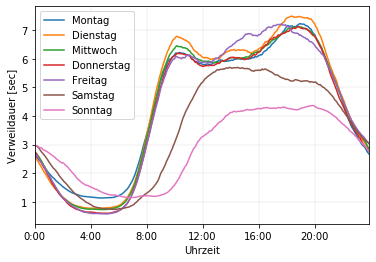

In [7]:
days = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]
joined = used_sensors
# setup a list of all sensor indices + 3 indices of dayofweek hour and minute
weekpredindexes = []
for el in joined:
    weekpredindexes += [data.columns.get_loc(el)]
# plot every weekday
for i,day in enumerate(days):
    ax = data.iloc[:,weekpredindexes].groupby(["dayofweek","hour","minute"]).mean().mean(axis=1)[i].plot(label=day, legend=True, figsize= (6,4))
# setup axes
ax.set_xlabel("Uhrzeit")
ax.set_ylabel("Verweildauer [sec]")
positions = [r for r in range(0,288,48)]
labels = [str(r)+":00" for r in range(0,24,4)]
ax.set_xticks(positions)
ax.set_xticklabels(labels)
# save
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.savefig('../Masterarbeit/Abbildungen/weekaverage.png', dpi = 300)

# Seperate training- , validation- and testdata

In [12]:
training_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1
max_index = len(data) -1
max_index = 40000
min_index_training = 8000
max_index_training = int(max_index*training_ratio)
min_index_validation = max_index_training + 1
max_index_validation = max_index_training + 1 + (int(max_index*validation_ratio))
min_index_test = max_index_validation +1 
max_index_test = max_index

# Normalization

In [13]:
# Create matrix from dataframe, drop columns which where only used for group by operation
float_data = data.drop(columns = ["dayofweek","hour","minute"]).values
#float_data = data.values

# Normalize data
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler(feature_range=[0,1]) 
scaler.fit(float_data[:max_index_training]) 
float_data_n = scaler.transform(float_data)

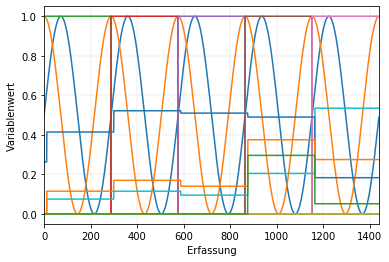

In [10]:
ax = pd.DataFrame(data=float_data_n).iloc[:1440,-13:].plot(legend = False, figsize= (6,4))
ax.set_xlabel("Erfassung")
ax.set_ylabel("Variablenwert")
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.savefig('../Masterarbeit/Abbildungen/skaliert.png', dpi = 300)

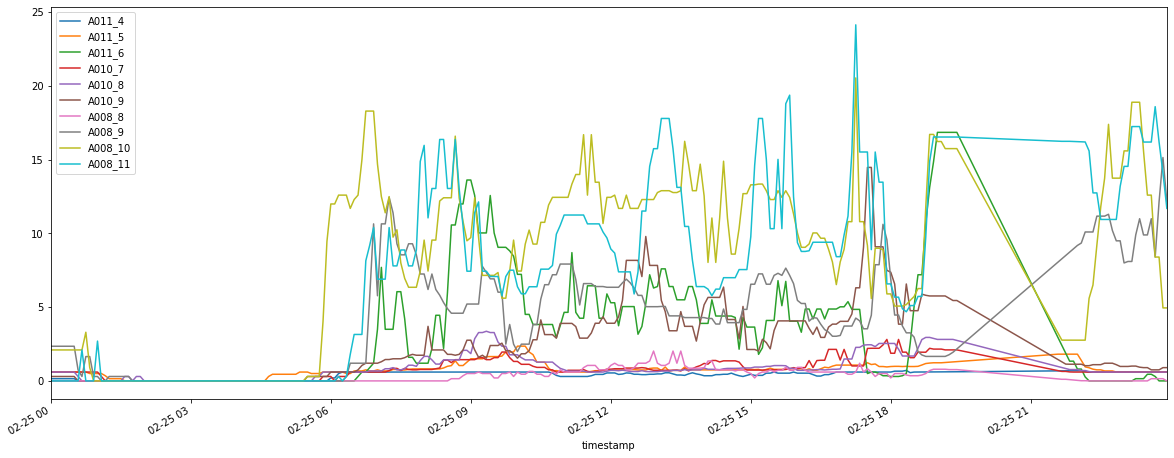

In [11]:
data.iloc[0:288].plot(y=['A011_4','A011_5','A011_6', 'A010_7', 'A010_8', 'A010_9', 'A008_8', 'A008_9', 'A008_10', 'A008_11'], figsize= (20,8))

# Setup generator functions

In [15]:
lookback = 36
step = 1
delay = 12 
batch_size = 128


train_gen = generator(indexes, float_data, float_data_n,
                      lookback=lookback,
                      delay=delay,
                      min_index=min_index_training,
                      max_index=max_index_training,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(indexes, float_data, float_data_n,
                    lookback=lookback,
                    delay=delay,
                    min_index=min_index_validation,
                    max_index=max_index_validation,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(indexes, float_data, float_data_n,
                     lookback=lookback,
                     delay=delay,
                     min_index=min_index_test,
                     max_index=max_index_test,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (max_index_validation - min_index_validation - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (max_index_test - min_index_test - lookback) // batch_size

In [16]:
data

,A008_1,A008_2,A008_3,A008_4,A008_5,A008_6,A008_7,A008_8,A008_9,A008_10,...,A182_2,A182_3,A182_4,A182_5,A182_6,A182_7,A200_1,hour,minute,dayofweek
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-25 00:00:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.45,6.4,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0
2019-02-25 00:05:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.45,6.4,0.0,0.0,0.1,0.0,0.0,0.0,5.0,0.0
2019-02-25 00:10:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.45,6.4,0.0,0.0,0.1,0.0,0.0,0.0,10.0,0.0
2019-02-25 00:15:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.45,6.4,0.0,0.0,0.1,0.0,0.0,0.0,15.0,0.0
2019-02-25 00:20:00+01:00,0.6,0.0,1.6,15.0,0.0,0.0,0.0,0.0,2.35,2.1,...,0.45,6.4,0.0,0.0,0.1,0.0,0.0,0.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-03 23:40:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,40.0,5.0
2019-08-03 23:45:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,45.0,5.0
2019-08-03 23:50:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,50.0,5.0


# Feature Engineering Wochentag und Zeit

Text(0, 0.5, 'Variablenwert')

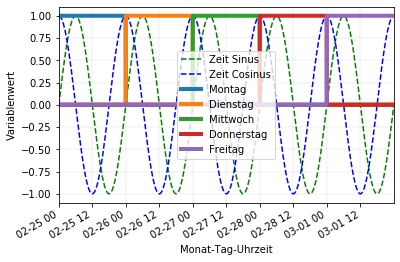

In [20]:
ax = data.iloc[:1440].sin_time.plot(label="Zeit Sinus", legend=True, figsize= (6,4), style = ["g--"])
data.iloc[:1440].cos_time.plot(label="Zeit Cosinus", legend=True, style = ["b--"])
data.iloc[:1440].monday.plot(label="Montag", legend=True, linewidth=4)
data.iloc[:1440].tuesday.plot(label="Dienstag", legend=True, linewidth=4)
data.iloc[:1440].wednesday.plot(label="Mittwoch", legend=True, linewidth=4)
data.iloc[:1440].thursday.plot(label="Donnerstag", legend=True, linewidth=4)
data.iloc[:1440].friday.plot(label="Freitag", legend=True, linewidth=4)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_xlabel("Monat-Tag-Uhrzeit")
ax.set_ylabel("Variablenwert")
#plt.savefig('../Masterarbeit/Abbildungen/feature_time.png', dpi = 300)

# Feature Engineering Wetter

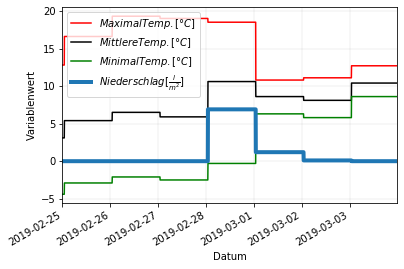

In [21]:
ax = data.iloc[:2016].Maximum.plot(label=r'$Maximal Temp. [°C]$', legend=True, color="red", )
data.iloc[:2016].Mittel.plot(label=r'$Mittlere Temp. [°C]$', legend=True, color="black")
data.iloc[:2016].Minimum.plot(label=r'$Minimal Temp. [°C]$', legend=True, figsize= (6,4), color="green")
data.iloc[:2016].Niederschlag.plot(label=r'$Niederschlag [\frac{l}{m^2}]$', legend=True, linewidth=4)
ax.set_xlabel("Datum")
ax.set_ylabel("Variablenwert")
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.savefig('../Masterarbeit/Abbildungen/weather_time.png', dpi = 300)

# Baseline Models

In our case, the timeseries can safely be assumed to be continuous as well as periodical with a daily period. Thus a common sense approach would be to always predict that historical average. Let's evaluate this approach, using the Mean Absolute Error metric (MAE).

In [13]:
evaluate_history(indexes, predict_sensors, data, min_index_training, max_index_training ,min_index_validation, max_index_validation)     

1.3065104757581738


1.7232342269776642


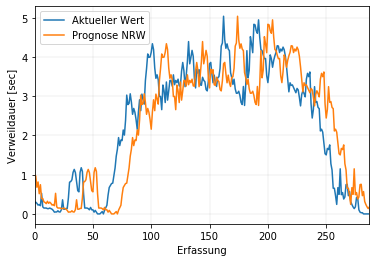

In [29]:
x, true, pred = naive_walk(indexes, data.values, min_index_validation, max_index_validation, delay)
ax = pd.DataFrame(data=true).iloc[:288].mean(axis=1).plot(figsize=(6,4), legend=True, label = "Aktueller Wert")
pd.DataFrame(data=pred).iloc[:288].mean(axis=1).plot(legend=True, label = "Prognose NRW")
ax.set_xlabel("Erfassung")
ax.set_ylabel("Verweildauer [sec]")
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.savefig('../Masterarbeit/Abbildungen/baseline_randomwalk.png', dpi = 300)

# Basic machine learning approach
Es muss der Punkt erreicht werden, an dem die Performance auf den Validierungsdaten wieder abnimmt.
Man benötigt ein Modell mit hoher Generalisierungsfähigkeit, d.h. einer guten Perfomance auch auf ungesehenen Daten.
Es sollte vermieden werden die Modellkapazität zu hoch anzusetzen, sodass die trainingsdaten auswendig gelernt werden.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 600)               2719200   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6010      
Total params: 2,725,210
Trainable params: 2,725,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 18s 351ms/step - loss: 1.5573 - mean_squared_error: 12.2401 - mean_absolute_error: 1.5573 - val_loss: 1.3172 - val_mean_squared_error: 8.5469 - val_mean_absolute_error: 1.3172
Epoch 2/50
50/50 [==============================] - 15s 296ms/step - loss: 1.2927 - mean_squared_error: 8.9979 - mean_absolute_error: 1.2927 - val_loss: 1.2531 - val_mean_squared_error: 7.9426 - val_mean_absolute_error: 1.2531
Epoch 3/50
50/50 [==============================] - 15s 295ms/step - loss

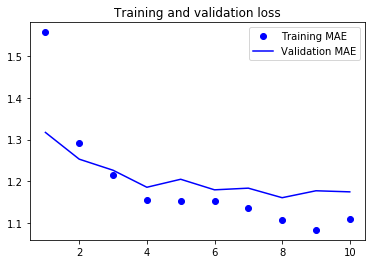

<Figure size 432x288 with 0 Axes>

In [17]:
#mode = "load"
mode = "training"
arch = "LSTM"
if arch == "LSTM":
    if mode== "training":
        model = ""
        model = Sequential()
        model.add(layers.CuDNNLSTM(600,  input_shape=(lookback//step, float_data.shape[-1])))
        model.add(layers.Dense(len(predict_sensors)))
        model.compile(optimizer= Adam(), loss='mae', metrics=['mse', 'mae'])
        model.summary()
        #plot_model(model, to_file='../Masterarbeit/Abbildungen/model_lstm.png', show_shapes = True)
        # simple early stopping
        # Set callback functions to early stop training and save the best model so far
        callbacks = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(filepath='lstm_model.h5', monitor='val_loss', save_best_only=True)]
        #train
        history = model.fit_generator(train_gen,steps_per_epoch=50,epochs=50,validation_data=val_gen,validation_steps=val_steps, callbacks=callbacks)
        # graphs
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, 'bo', label='Training MAE')
        plt.plot(epochs, val_loss, 'b', label='Validation MAE')
        plt.title('Training and validation loss')
        plt.legend()
        # setup axes
        #ax.set_xlabel("Epochen")
        #ax.set_ylabel("MAE")
        plt.show()
        plt.savefig('../Masterarbeit/Abbildungen/training_lstm.png', dpi = 300)
    else:
        model = load_model('lstm_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 19584)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 600)               11751000  
_________________________________________________________________
dense_3 (Dense)              (None, 300)               180300    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 11,962,410
Trainable params: 11,962,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 23s 231ms/step - loss: 1.7535 - mean_squared_error: 12.6162 - mean_absolute

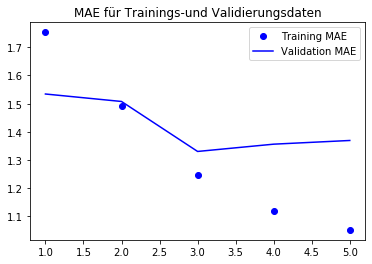

<Figure size 432x288 with 0 Axes>

In [44]:
arch="Dense"
if arch=="Dense":
    if mode== "training":
        model = ""
        model = Sequential()
        model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
        #model.add(layers.Dropout(0.2))
        model.add(layers.Dense(600, activation="relu"))
        model.add(layers.Dense(300, activation="relu"))
        model.add(layers.Dense(100, activation="relu"))
        model.add(layers.Dense(len(predict_sensors), activation='relu'))

        model.compile(optimizer=Adam(), loss='mae', metrics=['mse', 'mae'])
        model.summary()
        #plot_model(model, to_file='../Masterarbeit/Abbildungen/model_dnn.png', show_shapes = True)
        # Set callback functions to early stop training and save the best model so far
        callbacks = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(filepath='dnn_model.h5', monitor='val_loss', save_best_only=True)]
        #train        
        history = model.fit_generator(train_gen,
                                      steps_per_epoch=100,
                                      epochs=100,
                                      validation_data=val_gen,
                                      validation_steps=val_steps,
                                       callbacks= callbacks)

        # graphs
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, 'bo', label='Training MAE')
        plt.plot(epochs, val_loss, 'b', label='Validation MAE')
        plt.title('MAE für Trainings-und Validierungsdaten')
        plt.legend()
        # setup axes
        #ax.set_xlabel("Epochen")
        #ax.set_ylabel("MAE")
        plt.show()
        plt.savefig('../Masterarbeit/Abbildungen/training_dnn.png', dpi = 300)
    else:
        model = load_model('dnn_model.h5')

In [15]:
#plt.savefig('../Masterarbeit/Abbildungen/training_dnn_schritte12.svg', dpi = 200)

<Figure size 432x288 with 0 Axes>

# Evaluate Testdata

In [9]:
from keras.models import load_model
model = load_model('lstm_model.h5')
model.evaluate_generator(test_gen, steps=test_steps)

ValueError: Error when checking target: expected dense_1 to have shape (10,) but got array with shape (534,)

In [13]:
from keras.models import load_model
model = load_model('dnn_model.h5')
model.evaluate_generator(test_gen, steps=test_steps)

[1.7206265261915863, 14.094425791599711, 1.7206265261915863]

# Evaluate Training Data

In [41]:
from keras.models import load_model
model = load_model('dnn_model.h5')
model.evaluate_generator(val_gen, steps=val_steps)
#print(model.metrics_names)

[1.3579355816046397, 8.940509152412414, 1.3579355816046397]

In [38]:
delay

12

In [23]:
from keras.models import load_model
model = load_model('lstm_model.h5')
model.evaluate_generator(val_gen, steps=val_steps)
#print(model.metrics_names

[1.16735244790713, 7.3882874290148415, 1.16735244790713]

In [21]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'CuDNNLSTM',
   'config': {'name': 'cu_dnnlstm_1',
    'trainable': True,
    'batch_input_shape': (None, 36, 544),
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'units': 600,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'un

# Permutation Importance

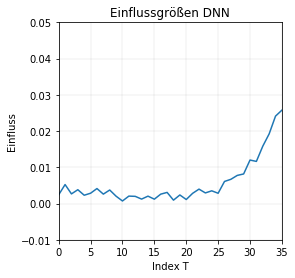

In [58]:
model = load_model('dnn_model.h5')

#define a score function. In this case I use accuracy
X, y = next(train_gen)
def score(X, y):
    y_pred = model.predict(X)
    return 1/mean_absolute_error(y, y_pred)

# This function takes only numpy arrays as inputs
base_score, score_decreases = get_score_importances(score, np.array(X), y)
feature_importances = np.mean(score_decreases, axis=0)

ax = pd.DataFrame(data = feature_importances).plot(legend=False, figsize = (4,4))
ax.set_ylim([-0.01,0.05])
ax.set_xlabel("Index T")
ax.set_ylabel("Einfluss")
ax.set_title('Einflussgrößen DNN')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

#plt.savefig('../Masterarbeit/Abbildungen/importance_dnn_time.png', dpi = 300, bbox_inches='tight')

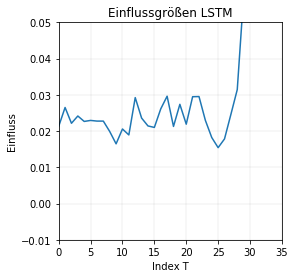

In [13]:
model = load_model('lstm_model.h5')

#define a score function. In this case I use accuracy
X, y = next(train_gen)
def score(X, y):
    y_pred = model.predict(X)
    return 1/mean_absolute_error(y, y_pred)

# This function takes only numpy arrays as inputs
base_score, score_decreases = get_score_importances(score, np.array(X), y)
feature_importances = np.mean(score_decreases, axis=0)

ax = pd.DataFrame(data = feature_importances).plot(legend=False, figsize = (4,4))
ax.set_ylim([-0.01,0.05])
ax.set_xlabel("Index T")
ax.set_ylabel("Einfluss")
ax.set_title('Einflussgrößen LSTM')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

#plt.savefig('../Masterarbeit/Abbildungen/importance_lstm_time.png', dpi = 300, bbox_inches='tight')

# Permutation Importance Features

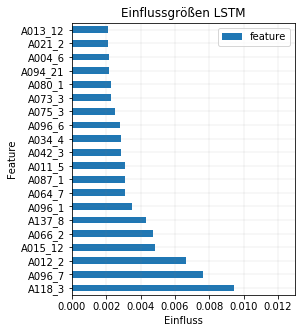

In [31]:
model = load_model('lstm_model.h5')

#define a score function.
X, y = next(train_gen)
def score(X, y):
    X = np.swapaxes(X,1,2)
    y_pred = model.predict(X)
    return 1/mean_absolute_error(y, y_pred)

# This function takes only numpy arrays as inputs
base_score, score_decreases = get_score_importances(score, np.array(np.swapaxes(X,1,2)), y)
feature_importances = np.mean(score_decreases, axis=0)

descriptions = data.columns.values
descriptions = np.delete( descriptions,[np.where(descriptions == 'hour'), np.where(descriptions ==  'minute'),np.where(descriptions == 'dayofweek')])
ax = pd.DataFrame(data = {'feature' : feature_importances}, index = descriptions).sort_values(by="feature", ascending=False)[:20].plot(figsize = (4,5), kind="barh")
ax.set_xlabel("Einfluss")
ax.set_ylabel("Feature")
ax.set_xlim([0,0.013])
ax.set_title('Einflussgrößen LSTM')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

#plt.savefig('../Masterarbeit/Abbildungen/importance_features_lstm.png', dpi = 300, bbox_inches='tight')

In [32]:
plt.savefig('../Masterarbeit/Abbildungen/importance_features_lstm_ohne_zus_merkmale.png', dpi = 300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

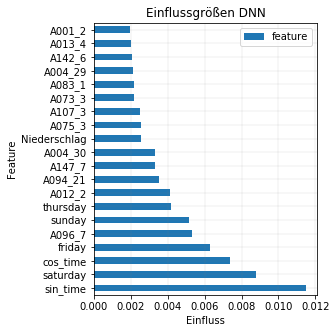

In [42]:
model = load_model('dnn_model.h5')

#define a score function
X, y = next(train_gen)
def score(X, y):
    X = np.swapaxes(X,1,2)
    y_pred = model.predict(X)
    return 1/mean_absolute_error(y, y_pred)

# This function takes only numpy arrays as inputs
base_score, score_decreases = get_score_importances(score, np.array(np.swapaxes(X,1,2)), y)
feature_importances = np.mean(score_decreases, axis=0)

descriptions = data.columns.values
descriptions = np.delete( descriptions,[np.where(descriptions == 'hour'), np.where(descriptions ==  'minute'),np.where(descriptions == 'dayofweek')])
ax = pd.DataFrame(data = {'feature' : feature_importances}, index = descriptions).sort_values(by="feature", ascending=False)[:20].plot(figsize = (4,5), kind="barh")
ax.set_xlabel("Einfluss")
ax.set_ylabel("Feature")
ax.set_xlim([0,0.013])
ax.set_title('Einflussgrößen DNN')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

#plt.savefig('../Masterarbeit/Abbildungen/importance_features_dnn.png', dpi = 300, bbox_inches='tight')

# Plot most important Sensors on Map

In [18]:
model = load_model('lstm_model.h5')

#define a score function.
X, y = next(train_gen)
def score(X, y):
    X = np.swapaxes(X,1,2)
    y_pred = model.predict(X)
    return 1/mean_absolute_error(y, y_pred)

# This function takes only numpy arrays as inputs
base_score, score_decreases = get_score_importances(score, np.array(np.swapaxes(X,1,2)), y)
feature_importances = np.mean(score_decreases, axis=0)

descriptions = data.columns.values
descriptions = np.delete( descriptions,[np.where(descriptions == 'hour'), np.where(descriptions ==  'minute'),np.where(descriptions == 'dayofweek')])

In [21]:
feature_importances

array([-6.37643444e-04, -4.81447640e-04, -1.04917577e-03, -1.80550500e-03,
       -1.57597732e-04,  9.65943795e-05, -1.18781893e-04, -2.94916798e-04,
       -4.08011186e-04, -6.50657805e-04, -3.44669303e-04,  2.14704849e-04,
        1.14857739e-03,  6.54664217e-04, -9.63333779e-04, -7.42426711e-04,
        1.42986709e-04,  5.02046098e-04, -6.40322222e-04, -2.27912006e-04,
        2.57101275e-04, -1.35228048e-04, -6.27321093e-04,  3.77580253e-04,
        2.64466141e-04,  1.06297013e-04, -3.04480986e-05,  1.53065101e-03,
       -3.01855064e-04,  5.23096962e-04,  7.22952649e-04, -3.86247616e-06,
        7.76111147e-03,  6.31002228e-04,  1.18140528e-03,  1.90655113e-03,
        2.53015508e-04, -4.88047414e-04,  2.75186501e-03, -1.22674210e-04,
        1.66397265e-04,  4.37324163e-05,  2.16366119e-03, -7.85193999e-04,
        8.09158548e-04,  8.94079514e-04,  7.26969825e-04, -5.14004384e-05,
        6.81634485e-04,  1.93285803e-04,  5.38430531e-05,  6.02051428e-05,
       -2.07383938e-04,  

In [49]:
day=1
hour=8
minute=0
from ipywidgets import HTML
sensorlist = sensors.create_sensor_list()
m = ""
m = Map(center=[49.88405869, 8.65147590],zoom=14)

descriptions = data.columns.values
descriptions = np.delete( descriptions,[np.where(descriptions == 'hour'), np.where(descriptions ==  'minute'),np.where(descriptions == 'dayofweek')])
feature_vis_data = pd.DataFrame(data = {'feature' : feature_importances}, index = descriptions).sort_values(by="feature", ascending=False)[:20]

vis_data = []
for sensor, influence in feature_vis_data.iterrows():
    lat = sensorlist[sensor]["Location"]["lat"]
    lon = sensorlist[sensor]["Location"]["lon"]
    if float(influence*1000) > 0:
        vis_data += [[lat, lon, round(float(influence*1000))]]
        
    circle_marker = CircleMarker()
    circle_marker.location = [lat,lon]
    circle_marker.radius = round(float(influence*3000))
    circle_marker.color = "red"
    circle_marker.fill = True
    circle_marker.fill_color = "red"
    #circle_marker.opacity = 0.8
    circle_marker.weight = 1    
    #marker = Marker(location=[lat,lon], opacity=0.5, draggable=False, title = str(sensor+" "+str(round(float(influence*1000)))))
    #m.add_layer(marker);
    # Popup with a given location on the map:
    popup = Popup(location=[lat,lon],child=HTML(sensor),close_button=False,auto_close=False,close_on_escape_key=False, max_height=40, max_width=20)
    #m.add_layer(popup)
    #circle_marker = CircleMarker(location = [lat,lon], radius = round(float(influence*1500)), color = "red")
    m.add_layer(circle_marker)

heat = Heatmap(locations= vis_data, radius=30, blur=10)
heat.max_zoom = 14
control = FullScreenControl()
m.add_control(control)
#heat.max = 30
#heat.gradient = {0.4: 'red', 0.6: 'yellow', 0.7: 'lime', 0.8: 'cyan', 1.0: 'blue'}
heat.gradient = {0.2: 'green', 0.3:'yellow', 0.4: 'orange', 0.6: 'red'}
#m.add_layer(heat)
m

missing: A093
missing: A114
missing: A115
missing: A121
missing: A124
missing: A129
missing: A133
missing: A138
missing: A140
missing: A152
missing: A153
missing: A156
missing: A157
missing: A158
missing: A166
missing: A172
missing: A174
missing: A185
missing: BSA225
missing: A044
missing: A103
missing: A119
missing: BSA004
missing: BSA005
missing: BSA232
missing: BSA900
missing: BSA901
missing: BSA905
missing: BSA914
missing: BSA915
missing: OCIT-Test
No data for following crossroads/ or these crossroads do not exist anymore:
['A093', 'A114', 'A115', 'A121', 'A124', 'A129', 'A138', 'A140', 'A152', 'A153', 'A156', 'A157', 'A158', 'A166', 'A172', 'A044', 'A103', 'A119']


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [ ]:
des

In [62]:
feature_vis_data.T

,A012_2,A096_7,A088_5,A047_2,A012_8,A081_1,A137_8,A023_9,A098_7,A088_7,A012_5,A041_4,A015_9,A003_6,A137_9,A043_9,A161_1,A080_2,A003_3,A005_6
feature,0.007761,0.004542,0.002971,0.002755,0.002752,0.002633,0.002341,0.002164,0.00209,0.001965,0.001907,0.001814,0.00173,0.001714,0.001686,0.001664,0.001552,0.00155,0.001547,0.001546


In [22]:
feature_vis_data

,feature
A012_2,0.007761
A096_7,0.004542
A088_5,0.002971
A047_2,0.002755
A012_8,0.002752
A081_1,0.002633
A137_8,0.002341
A023_9,0.002164
A098_7,0.002090
A088_7,0.001965


# Draw grid map of city with comparision between real and predicted data

In [84]:
i = 39000

for i in range(0,288)

array = np.zeros((batch_size,lookback, float_data.shape[-1]))
array[0] = float_data[i:i+lookback]
array_prediction = model.predict(array)[0]
array_real = float_data[i+lookback+delay,indexes]
print(mean_absolute_error(array_real, array_prediction))

grid_resolution = 10

draw_comparison(grid_resolution, array_real, array_prediction, index_dict)

SyntaxError: invalid syntax (<ipython-input-84-37caa221d385>, line 3)

# Draw prediction curve in comparison to real data for lstm-network

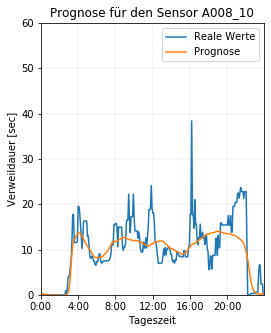

In [42]:
from keras.models import load_model
model = load_model('lstm_model.h5')
range_start = min_index_validation + 243
range_end =  min_index_validation + 243+ 288
# test prediction mean
array_real = []
array_prediction = []
for i in range(range_start, range_end):
    array = np.zeros((batch_size,lookback, float_data.shape[-1]))
    array[0] = float_data_n[i:i+lookback]
    #print(len(array))
    #array_prediction += [np.mean(model.predict(array)[0])]
    #array_real += [np.mean(float_data[i+lookback+delay,indexes])]
    array_prediction += [model.predict(array)[0][8]]
    array_real += [np.mean(float_data[i+lookback+delay,9])]    
df = pd.DataFrame(data = {'Reale Werte' : array_real, 'Prognose' : array_prediction})
ax = df.plot(figsize = (4,5))
ax.set_xlabel("Tageszeit")
ax.set_ylabel("Verweildauer [sec]")
ax.set_ylim([0,60])
positions = [r for r in range(0,288,48)]
labels = [str(r)+":00" for r in range(0,24,4)]
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_title('Prognose für den Sensor A008_10')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.savefig('../Masterarbeit/Abbildungen/ergebnisse_lstm_woche_mae.png', dpi = 300, bbox_inches='tight')
# Senosor A008_10 für 2019-06-17 00:00:00+02:00 bis 

In [20]:
index_dict

{'A011_4': 26,
 'A011_5': 27,
 'A011_6': 28,
 'A010_7': 20,
 'A010_8': 21,
 'A010_9': 22,
 'A008_8': 7,
 'A008_9': 8,
 'A008_10': 9,
 'A008_11': 10}

In [34]:
data.iloc[min_index_validation+243 + 576]

A008_1           0.600000
A008_2           2.100000
A008_3          21.600000
A008_4          18.300000
A008_5           0.533333
                  ...    
sunday           0.000000
Minimum         13.800000
Maximum         29.800000
Mittel          22.200000
Niederschlag     0.000000
Name: 2019-06-19 00:00:00+02:00, Length: 547, dtype: float64

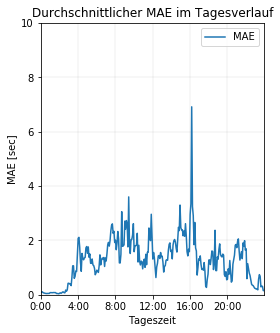

In [43]:
from keras.models import load_model
model = load_model('lstm_model.h5')
range_start = min_index_validation + 243
range_end =  min_index_validation + 243+ 288
# test prediction mean
array_real = []
mae = []
for i in range(range_start, range_end):
    array = np.zeros((batch_size,lookback, float_data.shape[-1]))
    array[0] = float_data_n[i:i+lookback]
    #print(len(array))
    mae += [mean_absolute_error(model.predict(array)[0] ,float_data[i+lookback+delay,indexes]) ]
df = pd.DataFrame(data = {'MAE' : mae})
ax = df.plot(figsize = (4,5))
ax.set_xlabel("Tageszeit")
ax.set_ylabel("MAE [sec]")
ax.set_ylim([0,10])
positions = [r for r in range(0,288,48)]
labels = [str(r)+":00" for r in range(0,24,4)]
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_title('Durchschnittlicher MAE im Tagesverlauf')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.savefig('../Masterarbeit/Abbildungen/ergebnisse_lstm_mae.png', dpi = 300, bbox_inches='tight')
# Senosor A008_10 für 2019-06-17 00:00:00+02:00 bis 

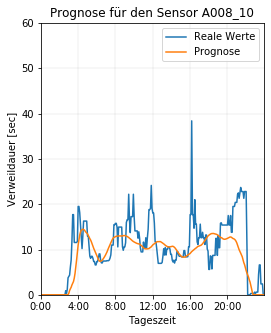

In [8]:
from keras.models import load_model
model = load_model('dnn_model.h5')
range_start = min_index_validation + 243
range_end =  min_index_validation + 243+ 288
# test prediction mean
array_real = []
array_prediction = []
for i in range(range_start, range_end):
    array = np.zeros((batch_size,lookback, float_data.shape[-1]))
    array[0] = float_data_n[i:i+lookback]
    #print(len(array))
    #array_prediction += [np.mean(model.predict(array)[0])]
    #array_real += [np.mean(float_data[i+lookback+delay,indexes])]
    array_prediction += [model.predict(array)[0][8]]
    array_real += [np.mean(float_data[i+lookback+delay,9])]    
df = pd.DataFrame(data = {'Reale Werte' : array_real, 'Prognose' : array_prediction})
ax = df.plot(figsize = (4,5))
ax.set_xlabel("Tageszeit")
ax.set_ylabel("Verweildauer [sec]")
ax.set_ylim([0,60])
positions = [r for r in range(0,288,48)]
labels = [str(r)+":00" for r in range(0,24,4)]
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_title('Prognose für den Sensor A008_10')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.savefig('../Masterarbeit/Abbildungen/ergebnisse_dnn_woche_mae.png', dpi = 300, bbox_inches='tight')
# Senosor A008_10 für 2019-06-17 00:00:00+02:00 bis 

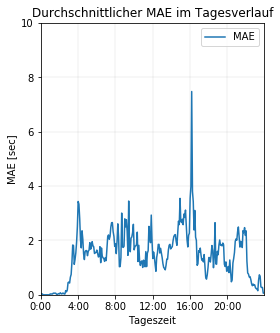

In [9]:
from keras.models import load_model
model = load_model('dnn_model.h5')
range_start = min_index_validation + 243
range_end =  min_index_validation + 243+ 288
# test prediction mean
array_real = []
mae = []
for i in range(range_start, range_end):
    array = np.zeros((batch_size,lookback, float_data.shape[-1]))
    array[0] = float_data_n[i:i+lookback]
    #print(len(array))
    mae += [mean_absolute_error(model.predict(array)[0] ,float_data[i+lookback+delay,indexes]) ]
df = pd.DataFrame(data = {'MAE' : mae})
ax = df.plot(figsize = (4,5))
ax.set_xlabel("Tageszeit")
ax.set_ylabel("MAE [sec]")
ax.set_ylim([0,10])
positions = [r for r in range(0,288,48)]
labels = [str(r)+":00" for r in range(0,24,4)]
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_title('Durchschnittlicher MAE im Tagesverlauf')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.savefig('../Masterarbeit/Abbildungen/ergebnisse_dnn_mae.png', dpi = 300, bbox_inches='tight')
# Senosor A008_10 für 2019-06-17 00:00:00+02:00 bis 

# Draw prediction curve in comparison to real data for dnn




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





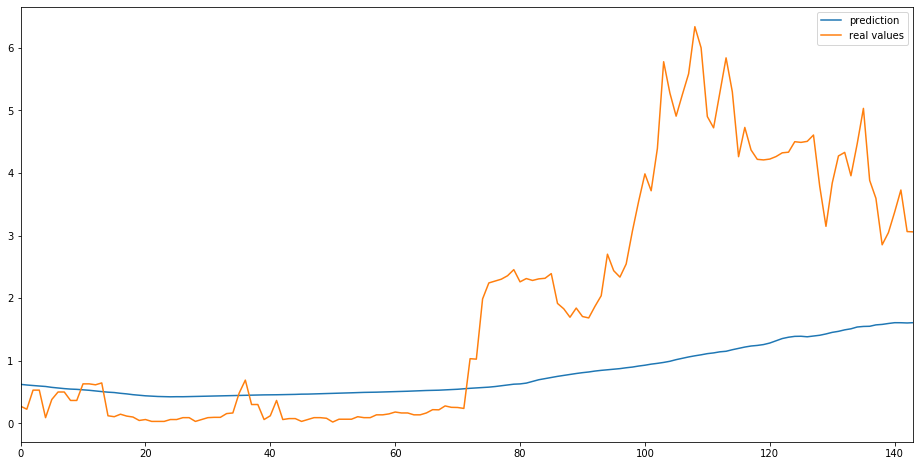

In [11]:
from keras.models import load_model
model = load_model('dnn_model.h5')
range_start = 40000
range_end =  40144
# test prediction mean
array_real = []
array_prediction = []
for i in range(range_start, range_end):
    array = np.zeros((batch_size,lookback, float_data.shape[-1]))
    array[0] = float_data_n[i:i+lookback]
    array_prediction += [np.mean(model.predict(array)[0])]
    array_real += [np.mean(float_data[i+lookback+delay,indexes])]
frame = pd.DataFrame()
frame["prediction"] = pd.Series(array_prediction)
frame["real values"] = pd.Series(array_real) 
frame.plot(legend=True, figsize= (16,8))

# Historic Data

In [27]:
from ipywidgets import HTML
# type in timestamp here: 
day=1 # weekday 1-6
hour=19
minute=0
sensorlist = sensors.create_sensor_list()
b = data.groupby(["dayofweek","hour","minute"])
heatmapdata = {}
m = Map(center=[49.88405869, 8.65147590],zoom=14)
predict_sensors = np.delete(predict_sensors ,[np.where(predict_sensors == 'hour'), np.where(predict_sensors ==  'minute'),np.where(predict_sensors == 'dayofweek')])

for i in predict_sensors:
    crossroad_id = sensorlist[i]["ID"]
    val = b[i].mean()[day][hour][minute]
    if not heatmapdata.get(crossroad_id):
        heatmapdata[crossroad_id] = {"lat": sensorlist[i]["Location"]["lat"], "lon": sensorlist[i]["Location"]["lon"], "val": [val]}
    else:
        heatmapdata[crossroad_id]["val"].append(val)

vis_data = []
for crossroad in heatmapdata.keys():
    average = np.mean(heatmapdata[crossroad]["val"])
    lat = heatmapdata[crossroad]["lat"] 
    lon = heatmapdata[crossroad]["lon"]
    vis_data += [[lat, lon, average]]
    #marker = Marker(location=[lat,lon], opacity=0.5, draggable=False, title = str(crossroad+" "+str(average)))
    #m.add_layer(marker);
    # Popup with a given location on the map:
    #popup = Popup(location=[lat,lon],child=HTML(crossroad),close_button=False,auto_close=False,close_on_escape_key=False, max_height=25, max_width=20)
    #m.add_layer(popup)
    circle_marker = CircleMarker(location = [lat,lon], radius = 1, color = "blue")
    m.add_layer(circle_marker)

heat = Heatmap(locations= vis_data, radius=35, blur=15)
heat.max_zoom = 14
control = FullScreenControl()
m.add_control(control)
heat.max = 30
#heat.gradient = {0.4: 'red', 0.6: 'yellow', 0.7: 'lime', 0.8: 'cyan', 1.0: 'blue'}
heat.gradient = {0.2: 'green', 0.4: 'orange', 0.6: 'red'}
m.add_layer(heat)
m

missing: A093
missing: A114
missing: A115
missing: A121
missing: A124
missing: A129
missing: A133
missing: A138
missing: A140
missing: A152
missing: A153
missing: A156
missing: A157
missing: A158
missing: A166
missing: A172
missing: A174
missing: A185
missing: BSA225
missing: A044
missing: A103
missing: A119
missing: BSA004
missing: BSA005
missing: BSA232
missing: BSA900
missing: BSA901
missing: BSA905
missing: BSA914
missing: BSA915
missing: OCIT-Test
No data for following crossroads/ or these crossroads do not exist anymore:
['A093', 'A114', 'A115', 'A121', 'A124', 'A129', 'A138', 'A140', 'A152', 'A153', 'A156', 'A157', 'A158', 'A166', 'A172', 'A044', 'A103', 'A119']


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …